In [1]:
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

import os
cwd = os.getcwd()

/home/carlos/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


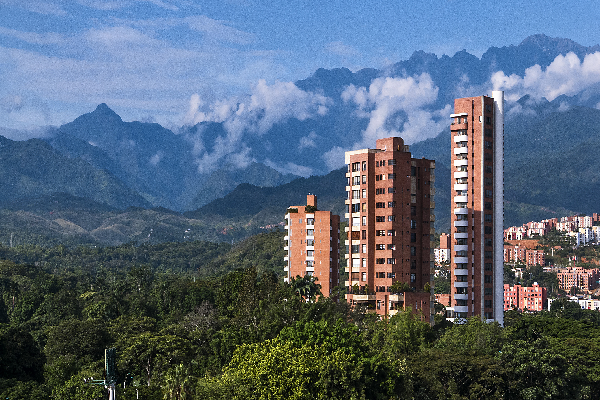

In [17]:
height = 400
width  = 600
cnt_name = 'cali'
content_image_path = cwd + '/content/' + cnt_name + '.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

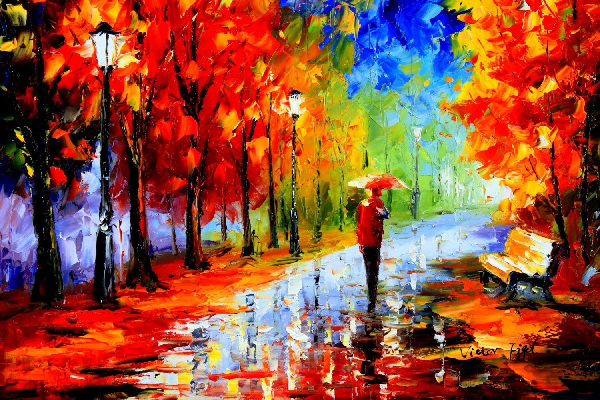

In [18]:
sty_name = 'rain'
style_image_path = cwd + '/style/' + sty_name + '.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [19]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
layers = dict([(layer.name, layer.output) for layer in model.layers])

content_weight = 0.1
style_weight = 10.0
total_variation_weight = 2.0

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

loss = backend.variable(0.)
def content_loss(content, combination):
    channels = 3
#    size = height * width
#    S = gram_matrix(combination)
#    C = gram_matrix(content)
    return backend.sum(backend.square(combination - content)) #+ 20*backend.sum(backend.square(S - C)) / (4. * (channels**2 ) * (size **2))

feature_layers = ['block2_conv2','block4_conv2','block4_conv1','block3_conv1', 'block3_conv2']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    content_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    #sl = style_loss(content_features, combination_features)
    loss += (content_weight / len(feature_layers))# * sl



content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2)) #+ 0.005*content_loss(style, combination)

feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv1', 'block4_conv3',
                  'block2_conv1']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
    
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

grads = backend.gradients(loss, combination_image)

outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

(1, 400, 600, 3)
(1, 400, 600, 3)


In [20]:
iterations = 12 
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128
X = np.zeros((iterations,height,width,3))


for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                    fprime=evaluator.grads, maxfun=20)
    X[i,...] = x.reshape((height, width, 3))
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 614195700000.0
Iteration 0 completed in 3s
Start of iteration 1
Current loss value: 290399300000.0
Iteration 1 completed in 3s
Start of iteration 2
Current loss value: 196757180000.0
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 159690180000.0
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 141626400000.0
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 129709980000.0
Iteration 5 completed in 3s
Start of iteration 6
Current loss value: 122559760000.0
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 117324685000.0
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 113610750000.0
Iteration 8 completed in 3s
Start of iteration 9
Current loss value: 111110330000.0
Iteration 9 completed in 3s
Start of iteration 10
Current loss value: 109034226000.0
Iteration 10 completed in 3s
Start of iteration 11
Current loss value: 107314360000.0
Iteration 11 comp

In [21]:
X[..., 0] += 104
X[..., 1] += 117
X[..., 2] += 124
X = np.clip(X, 0, 255).astype('uint8')

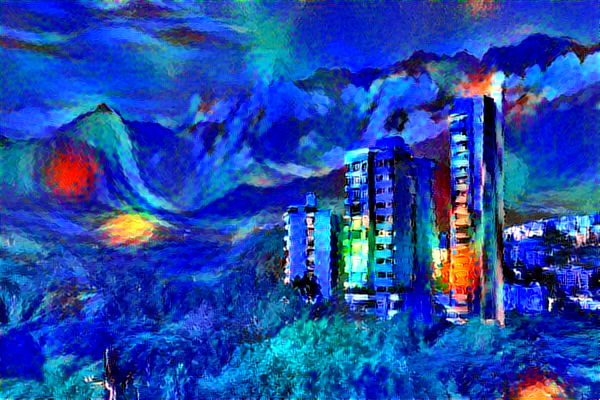

In [22]:
final_img = Image.fromarray(X[11,...]).resize((width, height))
final_img

In [25]:
imsave('results/' + cnt_name + '-' + sty_name + str(content_weight) + '03.jpg', final_img)

/home/carlos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


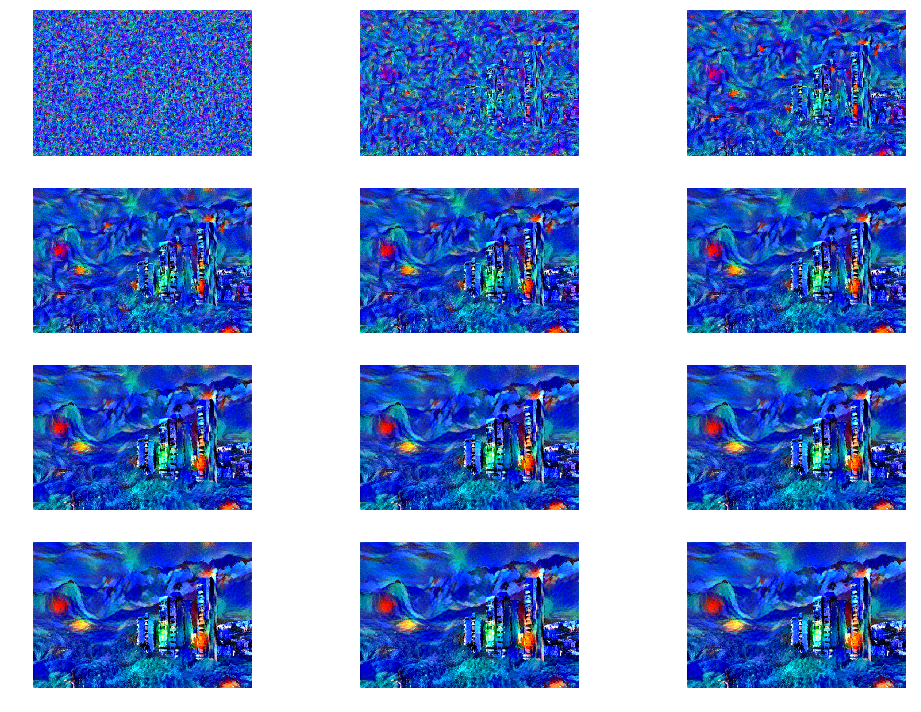

In [24]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(4,3, figsize=(14,10))
for i in range(12):
    ax[i//3,i%3].imshow(X[i,...])
    ax[i//3,i%3].axis('off')
plt.tight_layout()
plt.savefig('results/evolution_cali.pdf')
plt.show()    